In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/UTKFace.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [4]:
import os
import shutil

# Chemin vers le dossier UTKFace
utkface_folder = "/content/UTKFace"

# Créer un dossier de sortie
output_folder = "/content/UTKFaceN"
os.makedirs(output_folder, exist_ok=True)

# Définir les âges pour lesquels vous voulez collecter des images
ages_to_collect = list(range(1, 101))

# Nombre d'images à collecter par âge
images_per_age = 45

# Parcourir tous les fichiers dans le dossier UTKFace
for filename in os.listdir(utkface_folder):
    # Extraire l'âge du nom de fichier
    age = int(filename.split('_')[0])

    # Vérifier si l'âge est dans la liste des âges à collecter
    if age in ages_to_collect:
        # Copier le fichier dans le dossier UTKFaceM
        source_path = os.path.join(utkface_folder, filename)
        destination_path = os.path.join(output_folder, filename)
        shutil.copyfile(source_path, destination_path)

        # Décrémenter le nombre d'images à collecter pour cet âge
        images_per_age -= 1

        # Vérifier si vous avez collecté suffisamment d'images pour cet âge
        if images_per_age == 0:
            ages_to_collect.remove(age)
            images_per_age = 40  # Réinitialiser le nombre d'images à collecter pour le prochain âge

        if not ages_to_collect:
            break


In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Fonction de défloutage
def deblur_image(image):
    # Appliquer un filtre de déconvolution (inverse du filtre de flou gaussien)
    kernel = np.ones((5, 5), np.float32) / 25
    deblurred_image = cv2.filter2D(image, -1, kernel)
    return deblurred_image

# 1. Explorer la structure du jeu de données
data_path = "/content/UTKFaceN"
images = []
labels = []

for filename in os.listdir(data_path):
    if filename.endswith(".jpg"):
        # Les noms de fichiers dans UTKFace sont formatés comme "âge_genre_date_heure_minute_seconde.jpg"
        age = int(filename.split('_')[0])
        labels.append(age)
        img_path = os.path.join(data_path, filename)
        img = cv2.imread(img_path)
        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        # Ajout de prétraitements pour réduire le bruit
        img = cv2.resize(img, (224, 224))  # Redimensionner les images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir l'image en format RGB
        img = deblur_image(img)  # Appliquer le défloutage

        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        images.append(img)

# Convertir les listes en tableaux NumPy
images = np.array(images)
labels = np.array(labels)

# 2. Diviser le jeu de données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Normaliser les images (mise à l'échelle des pixels entre 0 et 1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set the TensorFlow v1 behavior
# tf.compat.v1.disable_eager_execution

# 4. Créer le modèle CNN
model = models.Sequential()

model.add(layers.Conv2D(128, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
#age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=3, strides=2))

model.add(layers.Conv2D(128, kernel_size=3, activation='relu'))
#age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=3, strides=2))

model.add(layers.Conv2D(256, kernel_size=3, activation='relu'))
#age_model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=3, strides=2))

model.add(layers.Conv2D(512, kernel_size=3, activation='relu'))
#age_model.add(Conv2D(512, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=3, strides=2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(1, activation='linear', name='age'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(model.summary())






Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 256)       0

In [6]:
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=70)

Epoch 1/70
72/72 [==============================] - 28s 202ms/step - loss: 1130.6869 - mae: 27.2076 - val_loss: 703.4536 - val_mae: 22.5727
Epoch 2/70
72/72 [==============================] - 12s 166ms/step - loss: 723.7614 - mae: 22.8743 - val_loss: 744.4503 - val_mae: 23.7782
Epoch 3/70
72/72 [==============================] - 11s 158ms/step - loss: 690.2001 - mae: 22.6373 - val_loss: 649.4557 - val_mae: 22.3898
Epoch 4/70
72/72 [==============================] - 11s 159ms/step - loss: 682.6218 - mae: 22.6066 - val_loss: 642.9858 - val_mae: 22.3740
Epoch 5/70
72/72 [==============================] - 11s 159ms/step - loss: 675.5692 - mae: 22.2675 - val_loss: 760.9947 - val_mae: 23.9408
Epoch 6/70
72/72 [==============================] - 11s 160ms/step - loss: 613.8302 - mae: 20.8708 - val_loss: 551.1575 - val_mae: 19.2015
Epoch 7/70
72/72 [==============================] - 12s 168ms/step - loss: 500.2522 - mae: 18.5128 - val_loss: 490.4770 - val_mae: 18.3324
Epoch 8/70
72/72 [========

In [7]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

16/16 [==============================] - 1s 48ms/step - loss: 179.6158 - mae: 10.1515
Test Loss: 179.61582946777344, Test MAE: 10.15152359008789


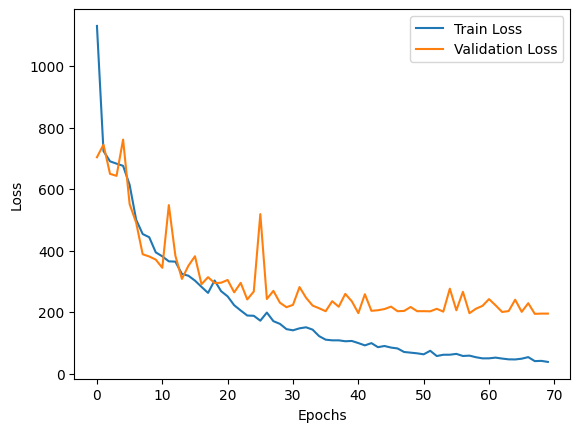

In [8]:
import matplotlib.pyplot as plt

# Afficher les courbes d'apprentissage
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 22ms/step
Prédiction d'âge : 43.75608825683594 ans


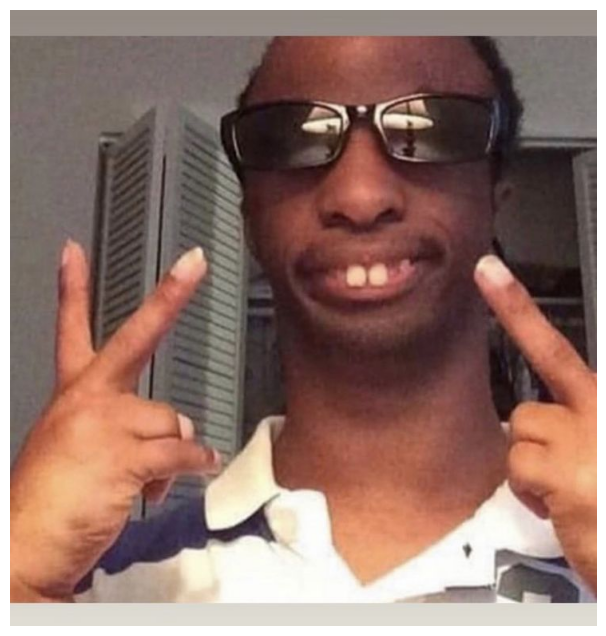

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model



# Charger et prétraiter l'image que vous souhaitez tester
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Assurez-vous de redimensionner l'image selon les spécifications de votre modèle
    img = img / 255.0  # Normalisation des pixels
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour représenter le lot (batch)
    return img

# Chemin de l'image que vous souhaitez tester
image_path = '/content/86106086e9594672ad7408913b5a3a24.jpg'

# Prétraiter l'image
processed_image = preprocess_image(image_path)

# Faire une prédiction avec le modèle
prediction = model.predict(processed_image)

# Afficher la prédiction
predicted_age = prediction[0][0]
print(f"Prédiction d'âge : {predicted_age} ans")
# Charger à nouveau l'image pour l'affichage
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Afficher l'image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


In [9]:
predictions = model.predict(X_test)
# Afficher les vrais âges et les prédictions sous forme de tableau
comparison_table = np.column_stack((y_test, predictions.flatten()))
print("Vrais Âges vs Prédictions d'Âge :\n", comparison_table)

16/16 [==============================] - 1s 45ms/step
Vrais Âges vs Prédictions d'Âge :
 [[ 3.70000000e+01  3.02603893e+01]
 [ 3.70000000e+01  4.74804001e+01]
 [ 7.60000000e+01  6.79258881e+01]
 [ 4.20000000e+01  5.69583092e+01]
 [ 7.30000000e+01  5.39889145e+01]
 [ 2.60000000e+01  3.62386475e+01]
 [ 4.40000000e+01  4.89939346e+01]
 [ 8.50000000e+01  9.01219559e+01]
 [ 1.00000000e+00  1.67005997e+01]
 [ 6.40000000e+01  5.32171059e+01]
 [ 1.00000000e+01  3.12047024e+01]
 [ 1.90000000e+01  2.58487663e+01]
 [ 7.60000000e+01  4.93425217e+01]
 [ 3.10000000e+01  3.51614037e+01]
 [ 7.90000000e+01  3.67317619e+01]
 [ 8.90000000e+01  5.29973679e+01]
 [ 4.80000000e+01  4.28966637e+01]
 [ 3.00000000e+01  2.67896175e+01]
 [ 6.60000000e+01  7.21495667e+01]
 [ 3.20000000e+01  3.57352982e+01]
 [ 1.10000000e+01  9.55408669e+00]
 [ 4.30000000e+01  6.10315895e+01]
 [ 9.00000000e+00  1.25620565e+01]
 [ 1.50000000e+01  1.34155245e+01]
 [ 4.00000000e+00  5.98282480e+00]
 [ 1.50000000e+01  1.82949543e+01]
 

In [10]:
# Afficher les images avec les prédictions d'âge comme titre
num_images_to_display = 10  # Vous pouvez ajuster le nombre d'images à afficher

for i in range(num_images_to_display):
    plt.figure(figsize=(8, 8))
    plt.imshow(X_test[i])
    true_age = y_test[i]
    predicted_age = predictions[0,0]
    plt.title(f'True Age: {true_age}, Predicted Age: {predicted_age:.2f}')
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcul des métriques
mae = mean_absolute_error(y_test, predictions.flatten())
mse = mean_squared_error(y_test, predictions.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions.flatten())

# Affichage des résultats
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

MAE: 10.15
MSE: 179.62
RMSE: 13.40
R^2: 0.74


In [12]:
tolerance = 10  # La fourchette acceptable autour de l'âge réel

# Calculer la précision
correct_predictions = np.sum(np.abs(y_test - predictions.flatten()) <= tolerance)
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions

# Afficher la précision
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 59.84%


In [13]:
model.save("/content/drive/MyDrive/CV/CNN.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
import tensorflow as tf

# Chargement d'un modèle pré-entraîné
modelCNN = tf.keras.models.load_model('/content/drive/MyDrive/CV/CNN.h5')




1/1 [==============================] - 1s 571ms/step
Prédiction d'âge : 56.93327713012695 ans


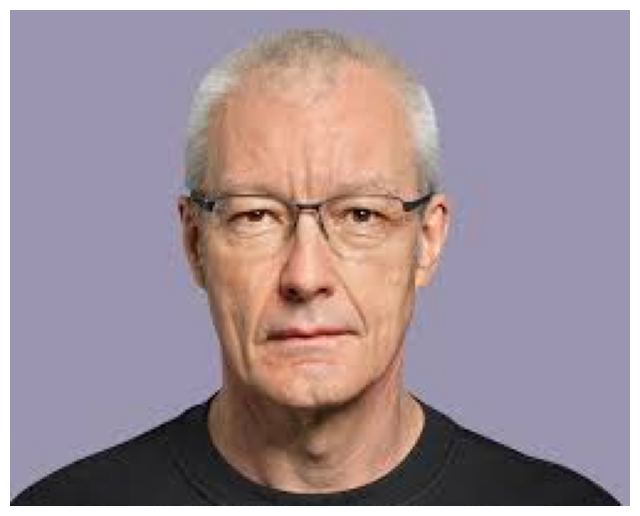

In [15]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model



# Charger et prétraiter l'image que vous souhaitez tester
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Assurez-vous de redimensionner l'image selon les spécifications de votre modèle
    img = img / 255.0  # Normalisation des pixels
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour représenter le lot (batch)
    return img

# Chemin de l'image que vous souhaitez tester
image_path = '/content/homme.jpeg'

# Prétraiter l'image
processed_image = preprocess_image(image_path)

# Faire une prédiction avec le modèle
prediction = modelCNN.predict(processed_image)

# Afficher la prédiction
predicted_age = prediction[0][0]
print(f"Prédiction d'âge : {predicted_age} ans")
# Charger à nouveau l'image pour l'affichage
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Afficher l'image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 18ms/step
Prédiction d'âge : 83.967041015625 ans


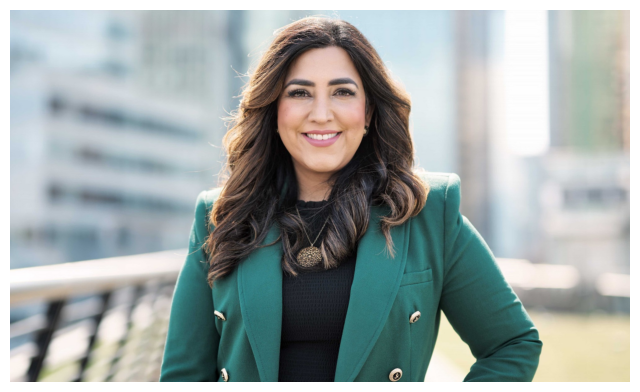

In [22]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model



# Charger et prétraiter l'image que vous souhaitez tester
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Assurez-vous de redimensionner l'image selon les spécifications de votre modèle
    img = img / 255.0  # Normalisation des pixels
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour représenter le lot (batch)
    return img

# Chemin de l'image que vous souhaitez tester
image_path = '/content/women2.jpg'

# Prétraiter l'image
processed_image = preprocess_image(image_path)

# Faire une prédiction avec le modèle
prediction = modelCNN.predict(processed_image)

# Afficher la prédiction
predicted_age = prediction[0][0]
print(f"Prédiction d'âge : {predicted_age} ans")
# Charger à nouveau l'image pour l'affichage
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Afficher l'image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 21ms/step
Prédiction d'âge : 67.09437561035156 ans


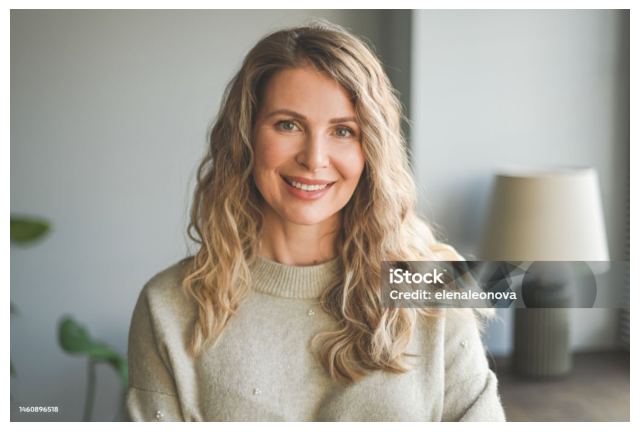

In [23]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model



# Charger et prétraiter l'image que vous souhaitez tester
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Assurez-vous de redimensionner l'image selon les spécifications de votre modèle
    img = img / 255.0  # Normalisation des pixels
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour représenter le lot (batch)
    return img

# Chemin de l'image que vous souhaitez tester
image_path = '/content/women3.jpg'

# Prétraiter l'image
processed_image = preprocess_image(image_path)

# Faire une prédiction avec le modèle
prediction = modelCNN.predict(processed_image)

# Afficher la prédiction
predicted_age = prediction[0][0]
print(f"Prédiction d'âge : {predicted_age} ans")
# Charger à nouveau l'image pour l'affichage
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Afficher l'image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


1/1 [==============================] - 5s 5s/step


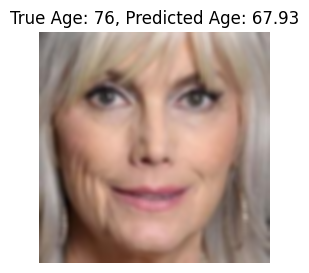

In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt


  # Redimensionner l'image pour qu'elle ait la forme attendue
resized_image = tf.image.resize(X_test[2], (224, 224))
resized_image = np.expand_dims(resized_image, axis=0)  # Ajouter la dimension de lot

plt.figure(figsize=(3, 3))  # Nouvelle taille de figure
plt.imshow(X_test[2])
true_age = y_test[2]

    # Faire la prédiction avec l'image redimensionnée
prediction = modelCNN.predict(resized_image)
predicted_age = prediction[0, 0]

plt.title(f'True Age: {true_age}, Predicted Age: {predicted_age:.2f}')
plt.axis('off')
plt.show()